In [1]:
print("Hello World")

Hello World


Pyspark contains two types of ensemble tree methods, Random Forest which I have been using up until this point and Gradient Boosted Trees
https://spark.apache.org/docs/latest/mllib-ensembles.html
These trees can not be trained in parallel so take longer to train. Gradient Trees work to minimise a loss function, while the Random Forest algoithims uses randomness, changing each Decision tree. I expect Random Forest to be more suitable for my purposes, as it is faster and I have a large dataset.
I would also have liked to have tried the J48 algorithim which was mentioned in some of the papers I read, but it is not available in Pyspark or SciKit Learn so implementing in in Java, which I have little experience of would have been to distracting. 

https://www.geeksforgeeks.org/building-a-machine-learning-model-using-j48-classifier/

I will continue using the minimal dimensions, for speed and we can bring dimensions back if the results are good

In [2]:
readFile="Data/parquet/subSampleWholeDataSet"

In [3]:
from pyspark.sql import SparkSession
import seaborn as sns
import matplotlib.pyplot as plt 
from pyspark.sql.functions import col

In [4]:
spark = SparkSession.builder \
    .master("local") \
    .appName("WiFi") \
    .config("spark.driver.memory", "8g")\
    .getOrCreate()

In [5]:
df=spark.read.parquet(readFile)

In [6]:
df.groupBy('StringLabel').count().show()
df.count()

+----------------+------+
|     StringLabel| count|
+----------------+------+
|           Krack|  2500|
|             SSH|  3541|
|          Botnet|  2725|
|            SSDP|  2622|
|   SQL_Injection|  2629|
|         RogueAP|  1310|
|       Evil_Twin|  3088|
|Website_spoofing|  2397|
|       (Re)Assoc|  3331|
|           Disas|  2957|
|          Normal|596802|
|          Deauth|  2249|
|           Kr00k|  3758|
|         Malware|  2498|
+----------------+------+



632407

https://docs.microsoft.com/en-us/azure/databricks/_static/notebooks/getting-started/get-started-with-mllib-dbr7.html as a guide

In [7]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

In [8]:
categoricalCols = [
    "wlan_tag_length",
    "wlan_country_info_fnm",
    "wlan_da",
    "wlan_sa",
    "wlan_bssid",
    "ip_src",
    "ip_dst"
]
   


In [9]:
# The following two lines are estimators. They return functions that we will later apply to transform the dataset.
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=[x + "index" for x in categoricalCols]).setHandleInvalid("keep") 
encoder = OneHotEncoder(inputCols=stringIndexer.getOutputCols(), outputCols=[x + "OHE" for x in categoricalCols]) 

In [10]:
numericCols=[
    "wlan_fixed_reason_code",
    "radiotap_channel_freq",
    "udp_length"
]

In [11]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
 
# This includes both the numeric columns and the one-hot encoded binary vector columns in our dataset.
assemblerInputs = [c + "OHE" for c in categoricalCols] + numericCols
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

we want to do a test train split 

In [12]:
train, test = df.randomSplit([0.8,0.2])


In [13]:
print('Events for the training {}'.format(train.count()))
print('Events for the validation {}'.format(test.count()))

Events for the training 506389
Events for the validation 126018


In [16]:
from pyspark.ml.classification import GBTClassifier

gbt = GBTClassifier(labelCol='label', featuresCol='features', maxIter=50, maxDepth=10)
pipeline2 = Pipeline(stages=[stringIndexer, encoder, vecAssembler,gbt])

In [17]:
%%time
train.cache()
pipelineModel = pipeline2.fit(train)
train.unpersist()

CPU times: user 2.34 s, sys: 1.82 s, total: 4.17 s
Wall time: 4h 31min 5s


DataFrame[frame_encap_type: int, frame_len: int, frame_number: int, frame_time: string, frame_time_delta: double, frame_time_delta_displayed: double, frame_time_epoch: double, frame_time_relative: double, radiotap_channel_flags_cck: int, radiotap_channel_flags_ofdm: int, radiotap_channel_freq: int, radiotap_datarate: double, radiotap_dbm_antsignal: int, radiotap_length: int, radiotap_mactime: double, radiotap_present_tsft: string, radiotap_rxflags: string, radiotap_timestamp_ts: bigint, radiotap_vendor_oui: int, wlan_duration: int, wlan_analysis_kck: string, wlan_analysis_kek: string, wlan_bssid: string, wlan_country_info_fnm: string, wlan_country_info_code: string, wlan_da: string, wlan_fc_ds: string, wlan_fc_frag: int, wlan_fc_order: int, wlan_fc_moredata: int, wlan_fc_protected: int, wlan_fc_pwrmgt: int, wlan_fc_type: int, wlan_fc_retry: int, wlan_fc_subtype: int, wlan_fcs_bad_checksum: int, wlan_fixed_beacon: int, wlan_fixed_capabilities_ess: int, wlan_fixed_capabilities_ibss: int,

In [18]:
%%time
test.cache()
pred = pipelineModel.transform(test)
test.unpersist()

CPU times: user 21.9 ms, sys: 2.05 ms, total: 24 ms
Wall time: 369 ms


DataFrame[frame_encap_type: int, frame_len: int, frame_number: int, frame_time: string, frame_time_delta: double, frame_time_delta_displayed: double, frame_time_epoch: double, frame_time_relative: double, radiotap_channel_flags_cck: int, radiotap_channel_flags_ofdm: int, radiotap_channel_freq: int, radiotap_datarate: double, radiotap_dbm_antsignal: int, radiotap_length: int, radiotap_mactime: double, radiotap_present_tsft: string, radiotap_rxflags: string, radiotap_timestamp_ts: bigint, radiotap_vendor_oui: int, wlan_duration: int, wlan_analysis_kck: string, wlan_analysis_kek: string, wlan_bssid: string, wlan_country_info_fnm: string, wlan_country_info_code: string, wlan_da: string, wlan_fc_ds: string, wlan_fc_frag: int, wlan_fc_order: int, wlan_fc_moredata: int, wlan_fc_protected: int, wlan_fc_pwrmgt: int, wlan_fc_type: int, wlan_fc_retry: int, wlan_fc_subtype: int, wlan_fcs_bad_checksum: int, wlan_fixed_beacon: int, wlan_fixed_capabilities_ess: int, wlan_fixed_capabilities_ibss: int,

In [19]:
pred_pd = pred.select(['label', 'prediction', 'probability']).toPandas()

In [20]:
pred_pd.head()

,label,prediction,probability
0,0,0.0,"[0.9784597430700719, 0.021540256929928114]"
1,0,0.0,"[0.9784597430700719, 0.021540256929928114]"
2,0,0.0,"[0.9784597430700719, 0.021540256929928114]"
3,0,0.0,"[0.9784597430700719, 0.021540256929928114]"
4,0,0.0,"[0.9784597430700719, 0.021540256929928114]"


In [21]:
>>> from sklearn.metrics import confusion_matrix

confusion_matrix(pred_pd['label'], pred_pd['prediction'])

array([[118952,     49],
       [   457,   6560]])

In [22]:
tn, fp, fn, tp = confusion_matrix(pred_pd['label'], pred_pd['prediction']).ravel()

In [23]:
print("There are "+str(tn)+ " true negatives")
print("There are "+str(tp)+ " true positives")
print("There are "+str(fn)+ " false negatives")
print("There are "+str(fp)+ " false positives")



There are 118952 true negatives
There are 6560 true positives
There are 457 false negatives
There are 49 false positives


So we have better performance than the Random Forest but a much longer run time on a small subsample

In [25]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import matthews_corrcoef

precision,recall,fscore,support = precision_recall_fscore_support(pred_pd['label'], pred_pd['prediction'], average='binary')
MCC = matthews_corrcoef(pred_pd['label'], pred_pd['prediction'])
print("The precision is "+str(precision))
print("The recall is "+str(recall))
print("The fscore is "+str(fscore))
print("The Matthews correlation coefficient is "+str(MCC))

The precision is 0.9925858677560901
The recall is 0.9348724526150777
The fscore is 0.9628651108175547
The Matthews correlation coefficient is 0.9612263650654274


The first tuning will be to increse the threshold. We want to plot the Presicion Recall curve and ROC curve. This is a better metric for imbalenced sets as we have here and why I used it in the crossvalidator

https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html



In [26]:
import numpy as np
pred_pd['probability'] = pred_pd['probability'].map(lambda x: list(x))
pred_pd['encoded_label'] = pred_pd['label'].map(lambda x: np.eye(2)[int(x)])

In [27]:
y_pred = np.array(pred_pd['probability'].tolist())
y_true = np.array(pred_pd['encoded_label'].tolist())

In [28]:
from sklearn.metrics import precision_recall_curve
precision, recall, threshold = precision_recall_curve( y_true[:,0], y_pred[:,0])


Exception ignored in: <function JavaWrapper.__del__ at 0x7f6b3d351430>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'GBTClassifier' object has no attribute '_java_obj'


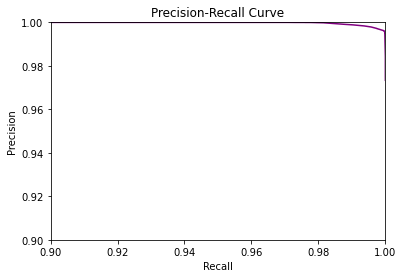

In [29]:
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='purple')
plt.xlim([0.90, 1])
plt.ylim([0.90, 1])

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

#display plot
plt.show()

In [30]:
#https://machinelearningmastery.com/threshold-moving-for-imbalanced-classification/ suggestion on setting thresholds
from numpy import argmax
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (threshold[ix], fscore[ix]))

Best Threshold=0.623785, F-Score=0.998


In [31]:
#taking 1-best threshold
threshold = 0.38
y_pred2 = (y_pred[:, 1] > threshold).astype('float')

tn, fp, fn, tp = confusion_matrix(pred_pd['label'], y_pred2).ravel()

In [32]:
print("There are "+str(tn)+ " true negatives")
print("There are "+str(tp)+ " true positives")
print("There are "+str(fn)+ " false negatives")
print("There are "+str(fp)+ " false positives")

There are 118952 true negatives
There are 6561 true positives
There are 456 false negatives
There are 49 false positives


In [33]:
precision,recall,fscore,support = precision_recall_fscore_support(pred_pd['label'], y_pred2, average='binary')
MCC2 = matthews_corrcoef(pred_pd['label'], y_pred2)
print("The precision is "+str(precision))
print("The recall is "+str(recall))
print("The fscore is "+str(fscore))
print("The Matthews correlation coefficient is "+str(MCC2))

The precision is 0.9925869894099849
The recall is 0.9350149636596836
The fscore is 0.9629412196374844
The Matthews correlation coefficient is 0.961304259456491


The results are excellent, but the run time will likely be impractical, we can see in the cloud if there are any options to run this algorithim for a long time in the back ground